<a href="https://colab.research.google.com/github/Makstarr/CURE-algorithm/blob/main/CURE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# СОЗДАНИЕ АЛГОРИТМА

## Импорт библиотек

In [2]:
import pandas as pd
import itertools 
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Функция чтения csv файлов, возвращает данные в формате массива и Pandas dataframe

In [3]:
def readDataset(data_file):
  data_frame = pd.read_csv(data_file, usecols = [0,2,5,6,7,8,9,10,11])
  data_frame.fillna(method ='ffill', inplace = True) 
  data_frame.head(2)
  data_array = data_frame[['Happiness.Score','Economy..GDP.per.Capita.','Family','Health..Life.Expectancy.', 'Freedom', 
          'Generosity','Trust..Government.Corruption.','Dystopia.Residual']] 
  data_array = data_array.to_numpy()
  #data_array = data_frame.to_numpy()
  return data_frame, data_array

## Класс кластер с методами расчета кластеров "изнутри" и свойствами каждого кластера

In [4]:
class Cluster(object):
    COUNTER = 0
    def __init__(self, points, p_ids, rep_count, alpha):
        Cluster.COUNTER += 1
        self.id = Cluster.COUNTER
        self.points = np.array(points) if type(points) == type([]) else points
        self.n_points, self.dimensions = self.points.shape
        self.p_ids = p_ids
        self.mean = None
        self.alpha = alpha
        self.rep_count = rep_count
        self.reps = self.assignReps()
        self.closest = None
        self.closestDist = sys.maxsize

    def getMean(self):
        if self.mean is not None:
            return self.mean
        self.mean = self.points.sum(axis=0)/(self.n_points*1.0)
        return self.mean
    
    def assignReps(self):
        if self.n_points <= self.rep_count:
            return self.points[:,:]
        tmp_set = set()
        reps = []
        for i in range(self.rep_count):
            max_dist = 0
            for j in range(self.n_points):
                if i == 0:
                    min_dist = Cluster.p_distance(self.points[j], self.getMean())
                else:
                    min_dist = self.getClosestDist(self.points[j], reps)
                if min_dist >= max_dist:
                    max_dist = min_dist
                    max_point = j
            if max_point not in tmp_set:
                tmp_set.add(max_point)
                if reps is not None:
                    point = self.points[max_point]
                    reps.append(point + self.alpha * (self.getMean() - point))
                else:
                    point = self.points[max_point]
                    reps = [point + self.alpha * (self.getMean() - point)]
        reps = np.array(reps)
        return reps
            
                    
    def getClosestDist(self, point, points):
        points = np.array(points)
        return min(np.sqrt(np.sum((points - point)**2, axis=1)))
    
    def __str__(self):
        return "[ID:%d] PointCount=%d, ClosestDist=%0.2f with [ID:%d]"%(self.id, self.n_points, self.closestDist, self.closest.id if self.closest else -1)
    
    def __repr(self):
        return self.__str__()
    


    @classmethod
    def merge(cls, cluster1, cluster2):
        if cluster1.dimensions != cluster2.dimensions:
            raise ValueError('Error! The dimensions of the data-points does not match.')
        
        combined_points = np.concatenate((cluster1.points, cluster2.points))
        combined_p_ids = cluster1.p_ids + cluster2.p_ids
        new_cluster = Cluster(combined_points, combined_p_ids, cluster1.rep_count, cluster1.alpha)
        
        new_cluster.mean = (cluster1.getMean()*cluster1.n_points + cluster2.getMean()*cluster2.n_points)/(new_cluster.n_points*1.0)

        return new_cluster
    
    def pointToClusterDistance(self, point):
        min_dist = sys.maxsize
        for rep_index in range(len(self.reps)):
            dist = Cluster.p_distance(self.reps[rep_index], point)
            min_dist = min(min_dist, dist)
        return min_dist
    
    @staticmethod
    def p_distance(point1, point2):
        return np.sqrt(np.sum((point1 - point2)**2))

    @staticmethod
    def c_distance(cluster1, cluster2):
        min_dist = sys.maxsize
        for rep_1_index in range(len(cluster1.reps)):
            for rep_2_index in range(len(cluster2.reps)):
                dist = Cluster.p_distance(cluster1.reps[rep_1_index], cluster2.reps[rep_2_index])
                min_dist = min(min_dist, dist)
        return min_dist

## Класс иерархической кластеризации с методами расчета кластеров "снаружи"


In [5]:
class HeirarchicalClustering(object):
    def __init__(self, cluster_count, rep_count, alpha):
        self.cluster_count = cluster_count
        self.clusters = []
        self.rep_count = rep_count
        self.alpha = alpha

    def fit(self, points):
        for p_index, point in enumerate(points):
            self.clusters.append(Cluster([point], [p_index], self.rep_count, self.alpha))
        
        for index in range(len(self.clusters)):
            self.assignClosestCluster(self.clusters[index])
            
        while len(self.clusters) > self.cluster_count:
            u_index = self.getMergeCandidate()
            u_cluster = self.clusters.pop(u_index)
            v_cluster = u_cluster.closest
            
            self.removeCluster(v_cluster)
            
            new_cluster = Cluster.merge(u_cluster, v_cluster)
            
            self.rebuildClosestClusterLinks(new_cluster, u_cluster.id, v_cluster.id)
            
            self.clusters.append(new_cluster)
    
    def predict(self, points):
        points = np.array(points)
        predictions = {cluster.id:[] for cluster in self.clusters}
        for i in range(len(points)):
            label = self.predict_point(points[i])
            predictions[label].append(i)
        return predictions.values()

    def predict_point(self, point):
        point = np.array(point)
        min_dist = sys.maxsize
        label = None
        for i in range(len(self.clusters)):
            dist = self.clusters[i].pointToClusterDistance(point)
            if dist < min_dist:
                min_dist = dist
                label = self.clusters[i].id
        return label
    
    def getMergeCandidate(self):
        min_dist = sys.maxsize
        cluster_index = 0
        for i in range(len(self.clusters)):
            dist = self.clusters[i].closestDist
            if dist < min_dist:
                min_dist = dist
                cluster_index = i
        return cluster_index
            
    def assignClosestCluster(self, cluster):
        min_dist = sys.maxsize
        closest = None
        for i in range(len(self.clusters)):
            if cluster.id == self.clusters[i].id: continue
            
            dist = Cluster.c_distance(cluster, self.clusters[i])
            if dist < min_dist:
                min_dist = dist
                closest = self.clusters[i]
        cluster.closest = closest
        cluster.closestDist = min_dist

    def rebuildClosestClusterLinks(self, new_cluster, cid_1, cid_2):
        min_dist = sys.maxsize
        for i in range(len(self.clusters)):
            new_dist = Cluster.c_distance(new_cluster, self.clusters[i])
            if new_cluster.closestDist > new_dist:
                new_cluster.closestDist = new_dist
                new_cluster.closest = self.clusters[i]

            if self.clusters[i].closest.id in (cid_1, cid_2):
                if self.clusters[i].closestDist < new_dist:
                    self.assignClosestCluster(self.clusters[i])
                else:
                    self.clusters[i].closestDist = new_dist
                    self.clusters[i].closest = new_cluster
            else:
                if self.clusters[i].closestDist > new_dist:
                    self.clusters[i].closestDist = new_dist
                    self.clusters[i].closest = new_cluster
    
    def removeCluster(self, cluster):
        for i in range(len(self.clusters)):
            if self.clusters[i].id == cluster.id:
                self.clusters[i] = self.clusters[-1]
                self.clusters.pop()
                return "Cluster not found"
        

## Функция сравнения результатов вычисления с любым другим методом кластеризации или (при наличии) верными кластерами

In [6]:
def calculateMetrics(pred_clusters, true_labels_arr):
    true_labels = {}
    for index, true_label in enumerate(true_labels_arr):
        if true_label in true_labels:
            true_labels[true_label].append(index)
        else:
            true_labels[true_label] = [index]
    true_labels = true_labels.values()
    true_label_pairs = []
    for true_cluster in true_labels:
        true_cluster.sort()
        true_label_pairs += itertools.combinations(true_cluster, 2)
    
    pred_label_pairs = []
    for index, pred_cluster in enumerate(pred_clusters):
        pred_cluster.sort()
       #print 'Cluster %d: %s\n'%(index+1, str(pred_cluster))
        pred_label_pairs += itertools.combinations(pred_cluster, 2)
    true_label_pairs = set(true_label_pairs)
    pred_label_pairs = set(pred_label_pairs)
    
    precision = len(pred_label_pairs.intersection(true_label_pairs))/(1.0*len(pred_label_pairs))
    recall = len(pred_label_pairs.intersection(true_label_pairs))/(1.0*len(true_label_pairs))
    f1 = 2*precision*recall/(precision+recall)
    return [("Precision: %0.2f, Recall: %0.2f"%(precision, recall)),  ("F1 score: %0.2f"%(f1))]

## Функция подбора альфа и числа итераций

In [7]:
def gridSearch(data, sample):    
  rep_counts = list(range(1, 6))    
  alphas = np.arange(0.1, 1, 0.1) 
  prints=[] 
  fits=[]
  answers = []
  for rep_count in rep_counts:        
    for alpha in alphas:            
      hc = HeirarchicalClustering(cluster_count, rep_count, alpha)            
      hc.fit(sample)            
      predictions = hc.predict(data)            
      prints.append('RepCount: %d, Alpha: %f'%(rep_count, alpha))         
      fits.append(calculateMetrics(predictions, AgglomerativeClustering(n_clusters=2).fit_predict(data)))
      answers.append([prints, fits])
  return answers


# РАСЧЕТНАЯ ЧАСТЬ

## Читаем датасет и считаем параметры для алгоритма

In [21]:
sample_file = '2017 copy.csv'
data_file = '2017.csv'

data = readDataset(data_file)[1]
sample = readDataset(data_file)[1]

data_set_full=readDataset(data_file)[0]

data_set_full

,Country,Happiness.Score,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182
...,...,...,...,...,...,...,...,...,...
150,Rwanda,3.471,0.368746,0.945707,0.326425,0.581844,0.252756,0.455220,0.540061
151,Syria,3.462,0.777153,0.396103,0.500533,0.081539,0.493664,0.151347,1.061574
152,Tanzania,3.349,0.511136,1.041990,0.364509,0.390018,0.354256,0.066035,0.621130
153,Burundi,2.905,0.091623,0.629794,0.151611,0.059901,0.204435,0.084148,1.683024


### Расчет числа кластеров Silhouette Score (Индекс оценки силуэта)

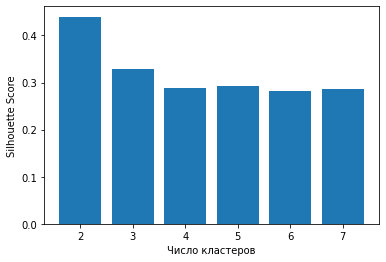

In [9]:
silhouette_scores = [] 
for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(data, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(data))) 

k = [2, 3, 4, 5, 6, 7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Число кластеров', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

In [10]:
cluster_count = 2

### Расчет комбинации альфа и числа итераций

In [11]:
#combination = gridSearch(data, sample)

## Выбираем параметры из рассчитанных вариантов

In [12]:
rep_count = 3
alpha = 0.8

## Считаем кластеры и смотрим их размеры

In [13]:
hc = HeirarchicalClustering(cluster_count, rep_count, alpha)
hc.fit(sample)
predictions = hc.predict(data)

In [14]:
len(list(predictions)[1])

92

In [15]:
len(list(predictions)[0])

63

## Создаем маркировки для кластеров

In [16]:
# Масисив числовой
colors_index = []
for i in range(len(data)):
  if (i in list(predictions)[1]):
    colors_index.append(1)
  elif (i in list(predictions)[0]):
    colors_index.append(0)
# Масисив цветов
colors = []
for i in colors_index:
  if (i==1):
      colors.append("#e98155")
  elif (i==0):
      colors.append("#9ee771")
  elif (i==2):
    colors.append("#f00")
  else:
    colors.append("#000")

## Рисуем график кластеров в 2D для выбранных факторов

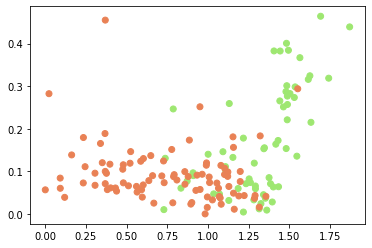

In [17]:
plt.scatter(data[:,1], data[:,6],  color = colors) 
plt.show()

## Наносим кластеры на карту мира (при наведении мыши на карту, показывается название страны)

In [33]:
mydata = [dict(type='choropleth',
             locations = 
data_set_full['Country'],
             locationmode = 'country names',
             z = colors_index,
             text = data_set_full['Country'],
             colorscale = [(0,"#9ee771"), (1,"#e98155")],
             colorbar = {'title':'Кластеры'})]
layout = dict(title='Групировка стран по кластерам',
              geo=dict(showframe = False, projection = {'type':'kavrayskiy7'})) #type = ['equirectangular', 'mercator', 'orthographic', 'natural earth', 'kavrayskiy7', 'miller', 'robinson', 'eckert4', 'azimuthal equal area', 'azimuthal equidistant', 'conic equal area', 'conic conformal', 'conic equidistant', 'gnomonic', 'stereographic', 'mollweide', 'hammer', 'transverse mercator', 'albers usa', 'winkel tripel', 'aitoff', 'sinusoidal']
map4 = dict(data=mydata, layout=layout)
iplot(map4)